In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile
from dsp import fm_demod
from utils import bandpass, lowpass, plot_signals,  welch

# TODO
 1. Where do PLL harmonics come from? Use different filter?
 2. Do we use good cutoff frequencies?
 3. Why is there such a delay between RDS subcarrier signal and demodulated signal?
 4. Matched filtering before timing recovery.
 5. Why demodulated signal has this very low frequency present modulating it's amplitude?
 6. Complex downconversion of RDS signal? (it's BPSK tho, should be symmetrical - question is if M & M works properly)
 7. What about biphase coding?

# Read and inspect the data
Source: [PySDR](https://pysdr.org/content/rds.html)

In [2]:
iq_samples = np.fromfile('data/fm_rds_250k_1Msamples.iq', dtype=np.complex64)

In [3]:
sample_rate = 250_000

In [4]:
iq_samples.shape

(1000000,)

/home/jakub/projects/SDR/SDR/env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:454: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


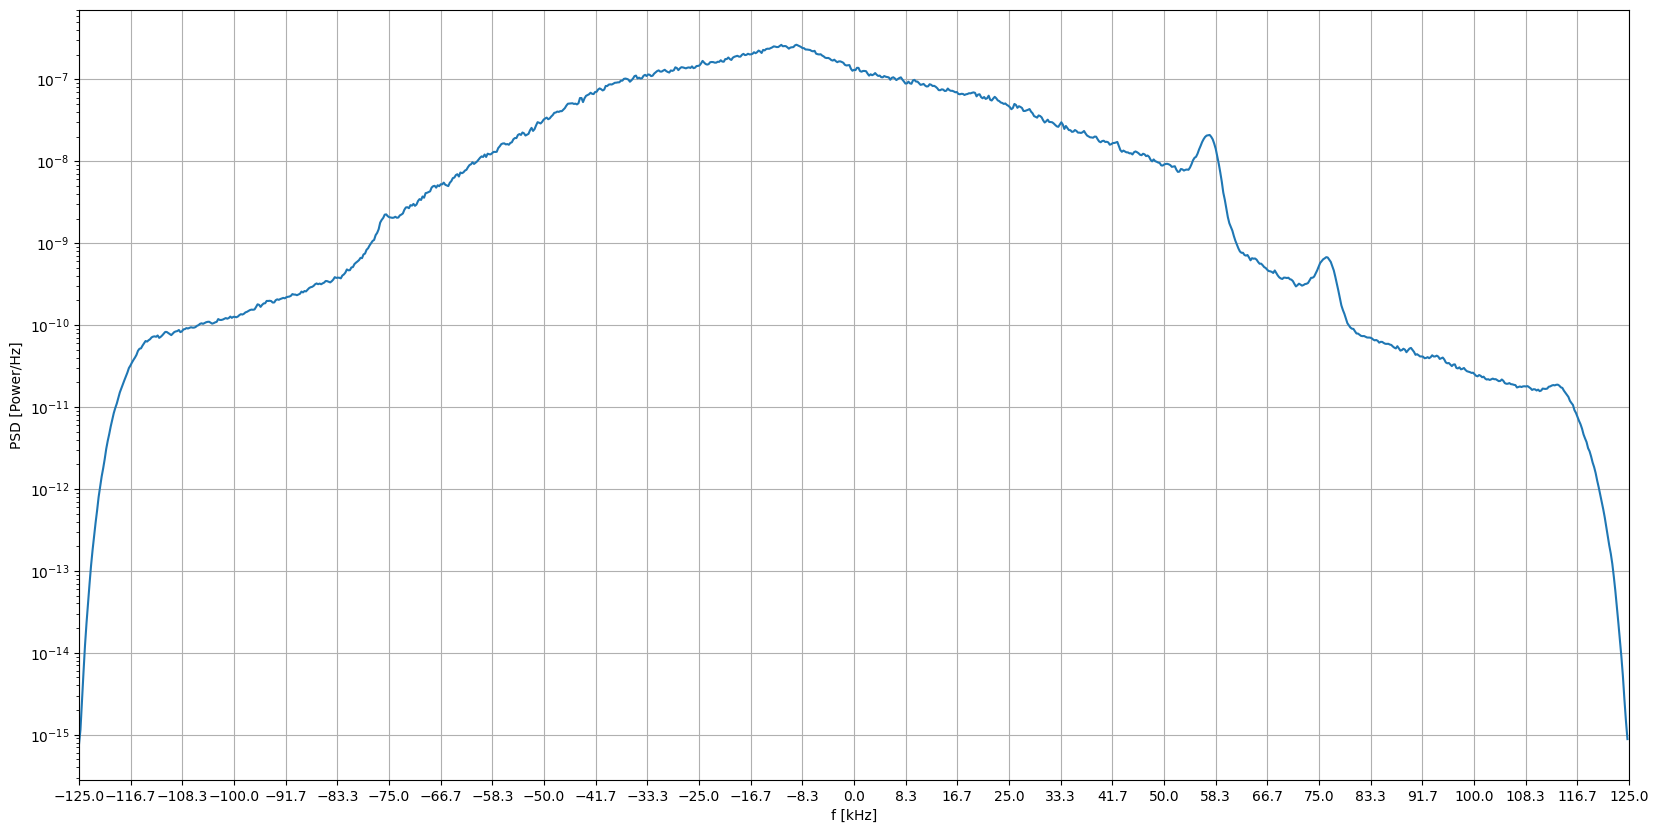

In [5]:
welch(iq_samples, sample_rate)

So we have an FM signal with about 250kHz bandwidth, downconverted to baseband.

# Demodulate FM signal

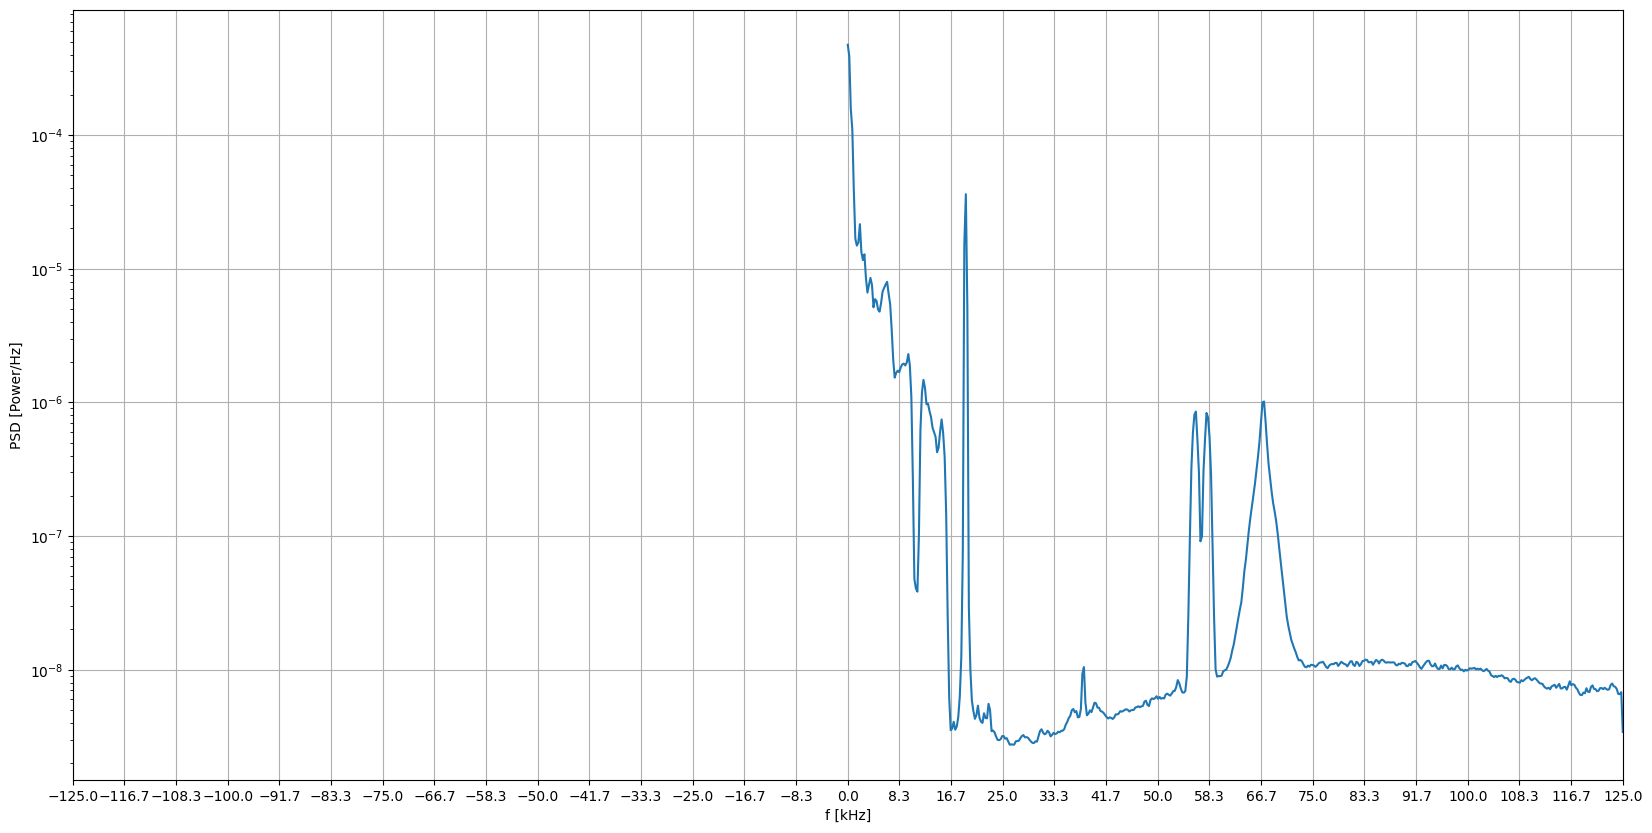

In [6]:
fm_modulating_signal = fm_demod(iq_samples)
welch(fm_modulating_signal, sample_rate)

Picture-perfect - we can clearly see:
 - audio band up to around 16kHz
 - strong pilot tone at 19kHz
 - weak FM stereo signal at 38kHz
 - strong RDS BPSK signal at 57kHz
 - [DirectBand](https://en.wikipedia.org/wiki/DirectBand) signal at 67 kHz

# Lock onto pilot tone
Bandpass filter the pilot tone and use a phase-locked loop to get phase estimates. These can be later used to demodulate 57kHz RDS signal since it should be locked in-phase to the pilot. We use +/- 2.4kHz for filtering of the pilot

In [7]:
def calc_loop_params(damping_factor, noise_bandwidth, sample_rate, ped_gain=0.5, nco_gain=1):
    k_p = (4 * damping_factor * noise_bandwidth) / (ped_gain * nco_gain * (damping_factor + 1 / (4 * damping_factor)) * sample_rate)
    k_i = (4 * noise_bandwidth ** 2) / (ped_gain * nco_gain * ((damping_factor + 1 / (4 * damping_factor)) * sample_rate) ** 2)
    return k_p, k_i

k_p, k_i = calc_loop_params(damping_factor=1 / np.sqrt(2),noise_bandwidth=0.05 * sample_rate, sample_rate=sample_rate)
k_p, k_i

(0.26666666666666666, 0.01777777777777778)

In [8]:
def pll(input_signal, sample_rate, base_frequency, k_p, k_i, nco_gain):
    phases, errors = np.zeros(len(input_signal)), np.zeros(len(input_signal))
    integrator_acc, phase = 0, 0
    
    for i, sample in enumerate(input_signal):
        # cos here means phases will be for use in sin function
        error = np.cos(2 * np.pi * base_frequency * i / sample_rate + phase) * sample
        
        integrator_acc += (k_i * error)
        phase += (nco_gain * (integrator_acc + k_p * error))

        phases[i] = phase
        errors[i] = error
        
    return phases, errors

In [9]:
pilot_frequency_hz = 19000
pilot_bandwidth_hz = 2400
pilot_signal = bandpass(fm_modulating_signal, sample_rate, pilot_frequency_hz - pilot_bandwidth_hz / 2, pilot_frequency_hz + pilot_bandwidth_hz / 2, N=6)

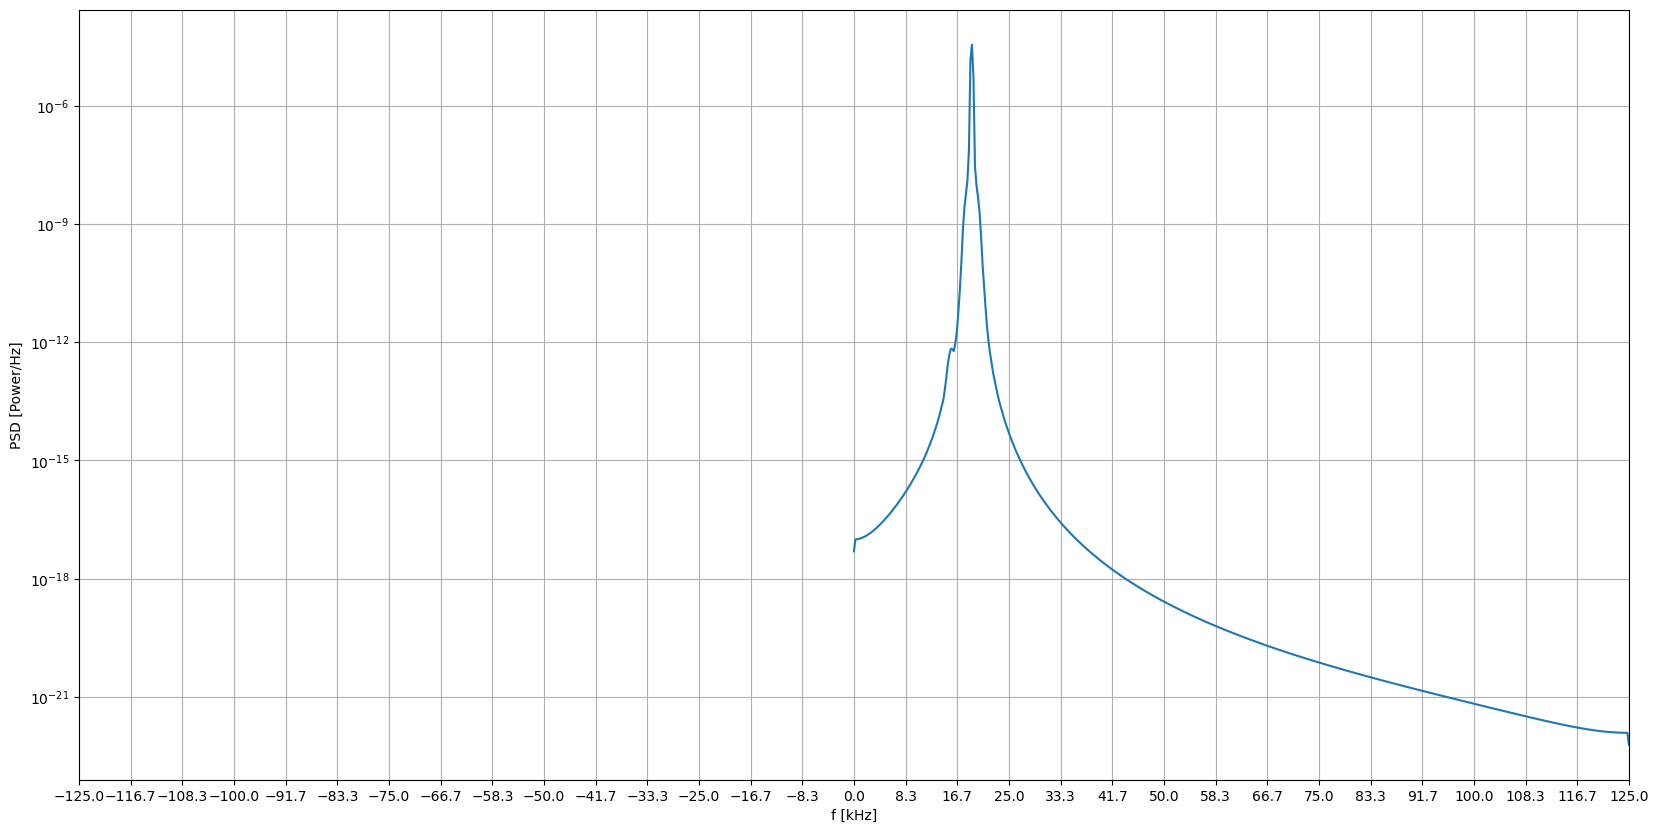

In [10]:
welch(pilot_signal, sample_rate)

Interestingly, number of Butterworth filter coefficients cannot be much higher because apparently numeric overflows occur during filtering. 6 seems like a balance between cutoff quality and complexity.

In [11]:
phases, errors = pll(pilot_signal, sample_rate, pilot_frequency_hz, k_p, k_i, 1)

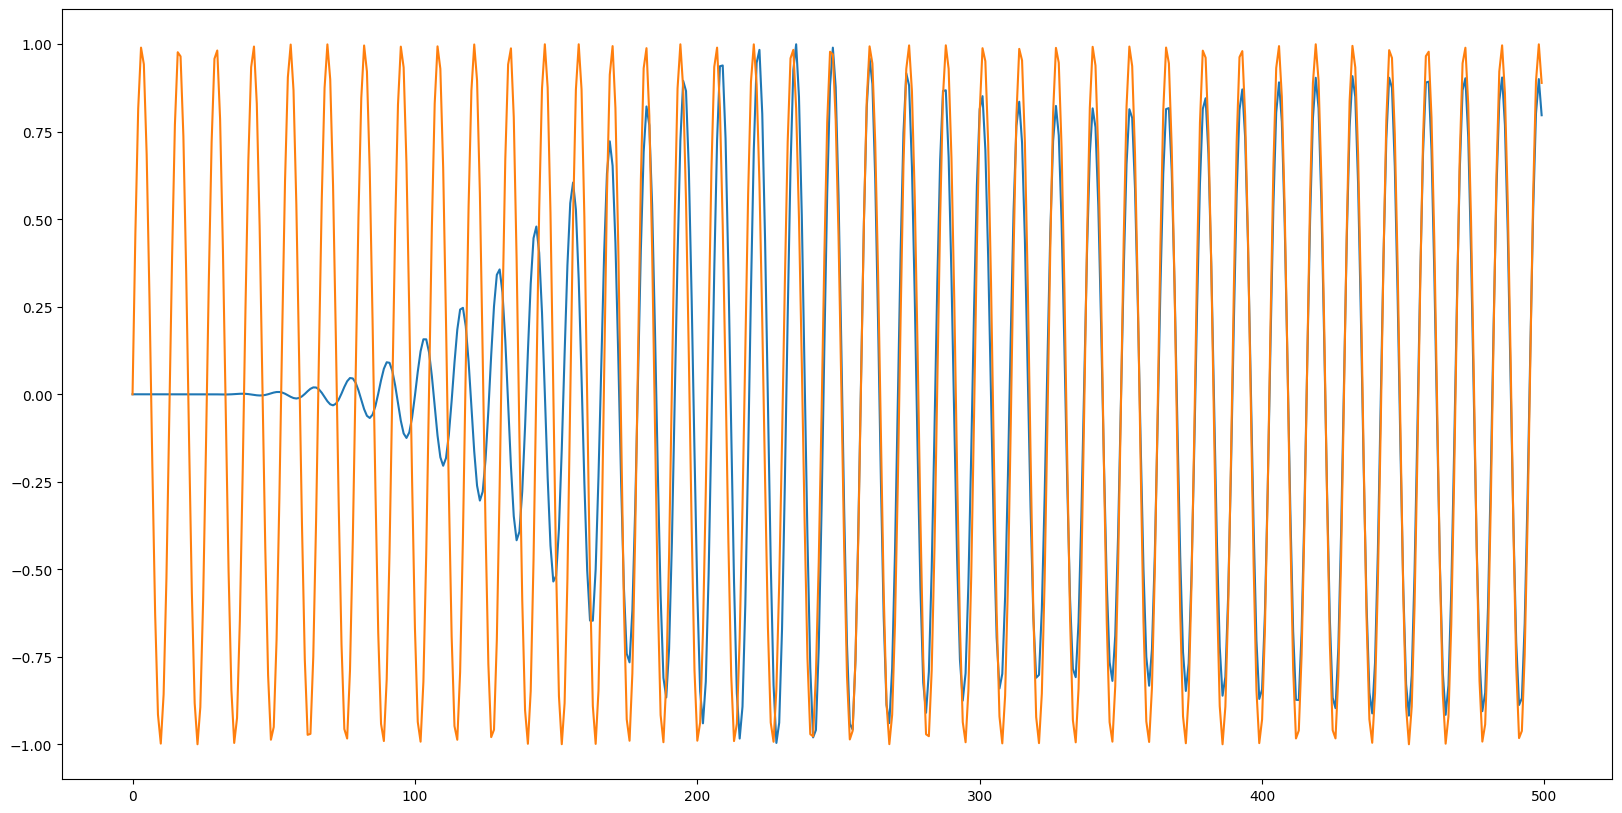

In [12]:
t_s = np.arange(0, len(pilot_signal) / sample_rate, 1 / sample_rate)
recovered_pilot_signal = np.sin(2 * np.pi * pilot_frequency_hz * t_s + phases)
plot_signals([pilot_signal, recovered_pilot_signal], start=0, width=500)

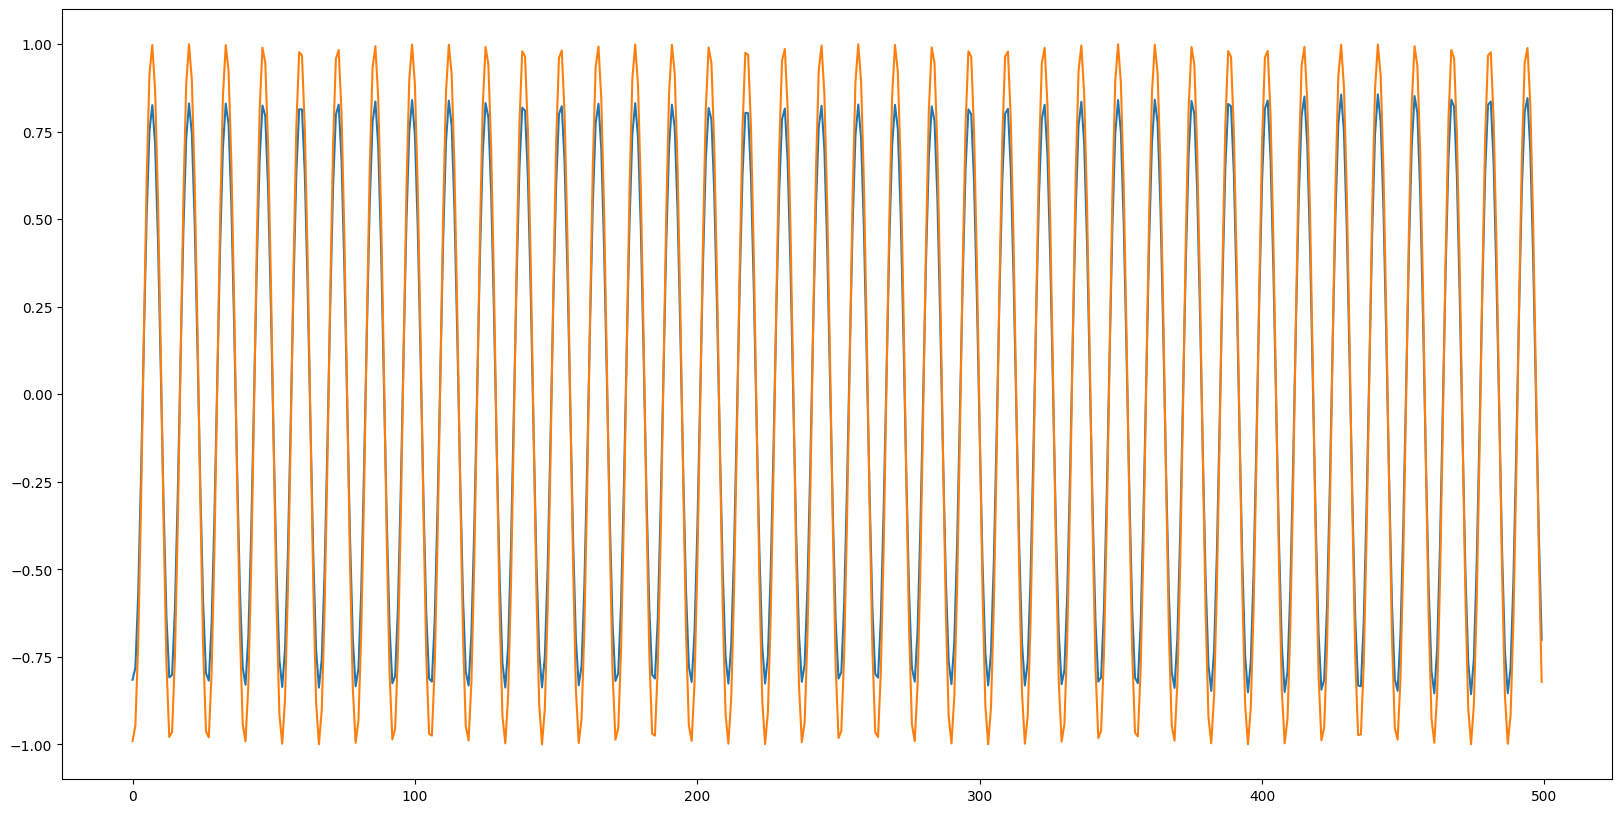

In [13]:
plot_signals([pilot_signal, recovered_pilot_signal], start=200_000, width=500)

Hopefully we have achieved sync. Let's take a look at spectrum of recovered pilot signal.

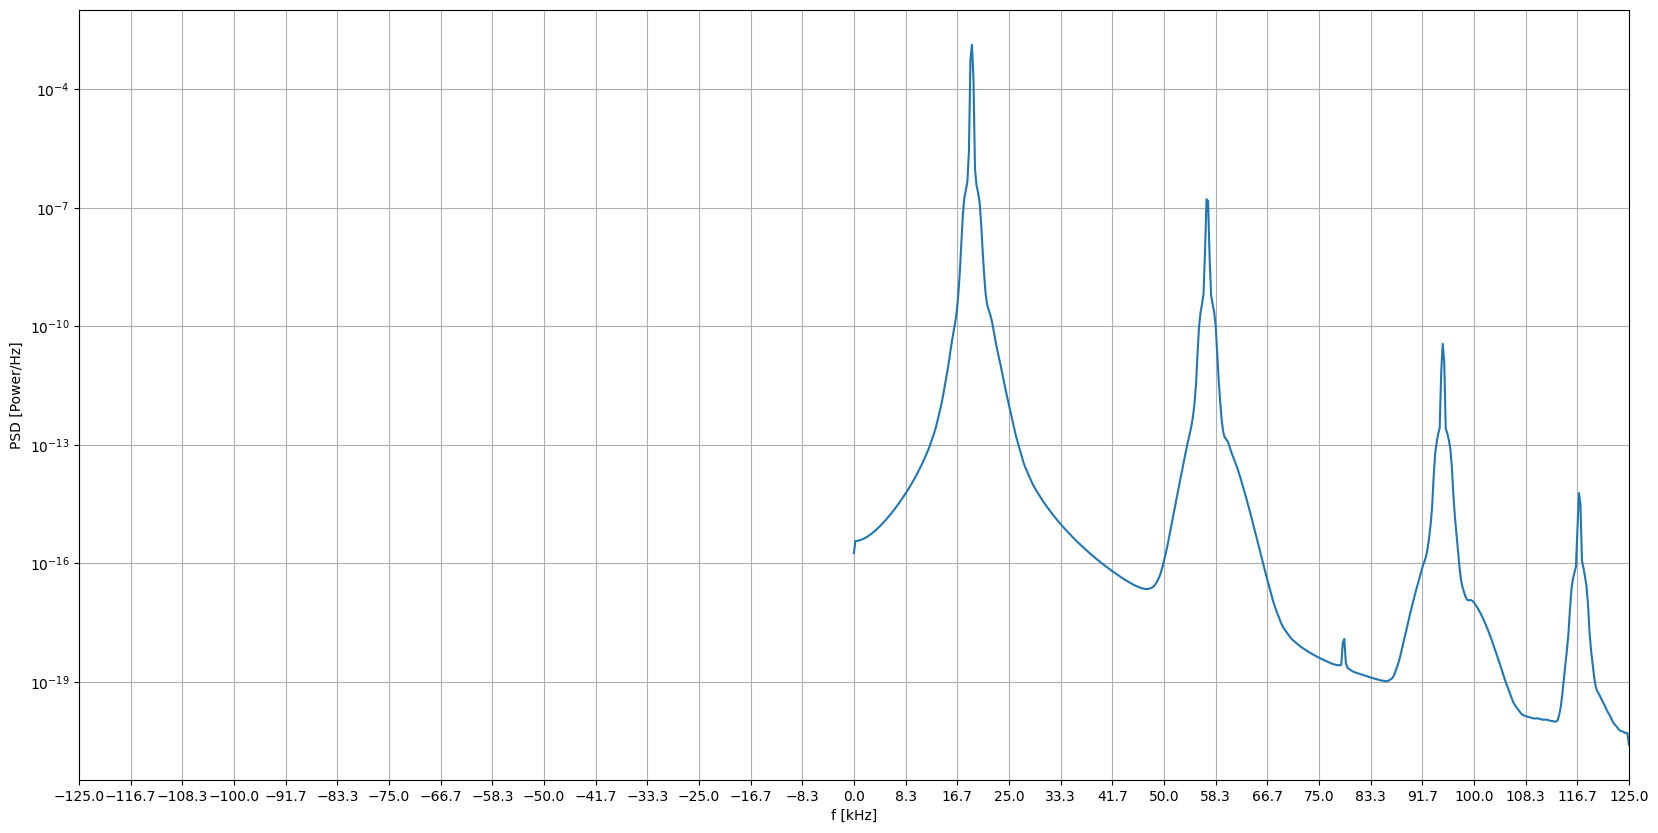

In [14]:
welch(recovered_pilot_signal, sample_rate)

Very interesting. We get multiple harmonics of the pilot tone. It's probably because of the harmonics in phase signal - perhaps PLL filter should be adjusted?

These harmonics are also present in our recovered RDS subcarrier (after multiplying phase by 3), so **we'll need to bandpass filter it before modulation**!

# Demodulate BPSK signal at 57kHz subcarrier
Bandpass filter the RDS signal and use 3x our phase estimates for pilot to demodulate the BPSK signal.

In [15]:
rds_frequency_hz = 57000
rds_bandwidth_hz = 4800
rds_signal = bandpass(fm_modulating_signal, sample_rate, rds_frequency_hz - rds_bandwidth_hz / 2, rds_frequency_hz + rds_bandwidth_hz / 2, N=8)

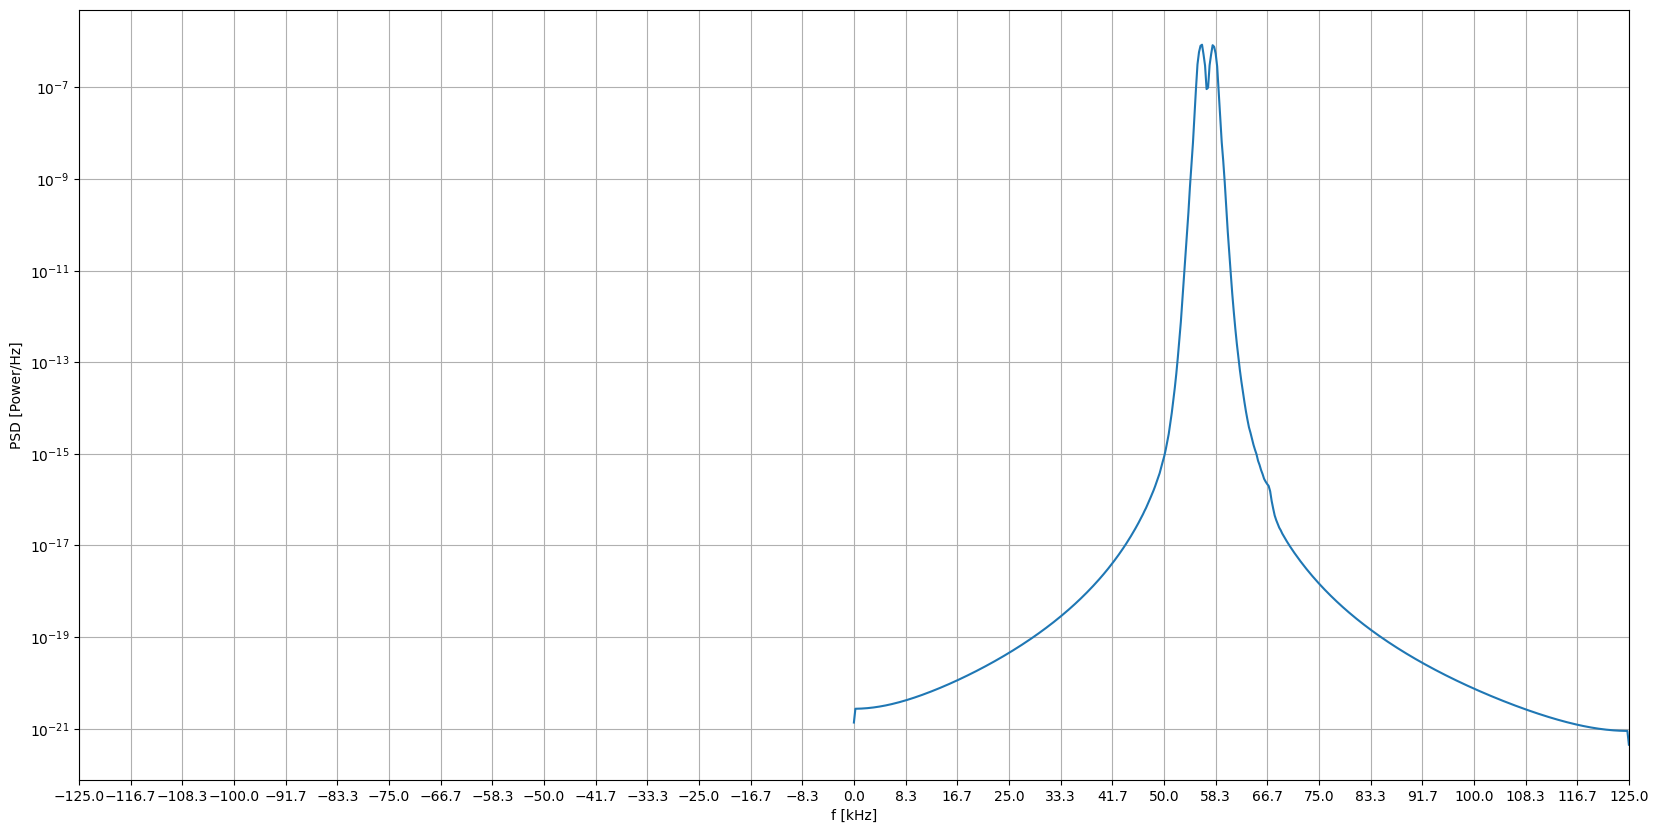

In [16]:
welch(rds_signal, sample_rate)

In [77]:
recovered_rds_subcarrier = np.sin(3 * (2 * np.pi * pilot_frequency_hz * t_s + phases))
recovered_rds_subcarrier_no_harmonics = bandpass(
    recovered_rds_subcarrier, sample_rate, rds_frequency_hz - rds_bandwidth_hz / 2, rds_frequency_hz + rds_bandwidth_hz / 2, N=8
)
rds_signal_shifted = rds_signal * recovered_rds_subcarrier_no_harmonics
rds_signal_demodulated = lowpass(rds_signal_shifted, sample_rate, 4800)

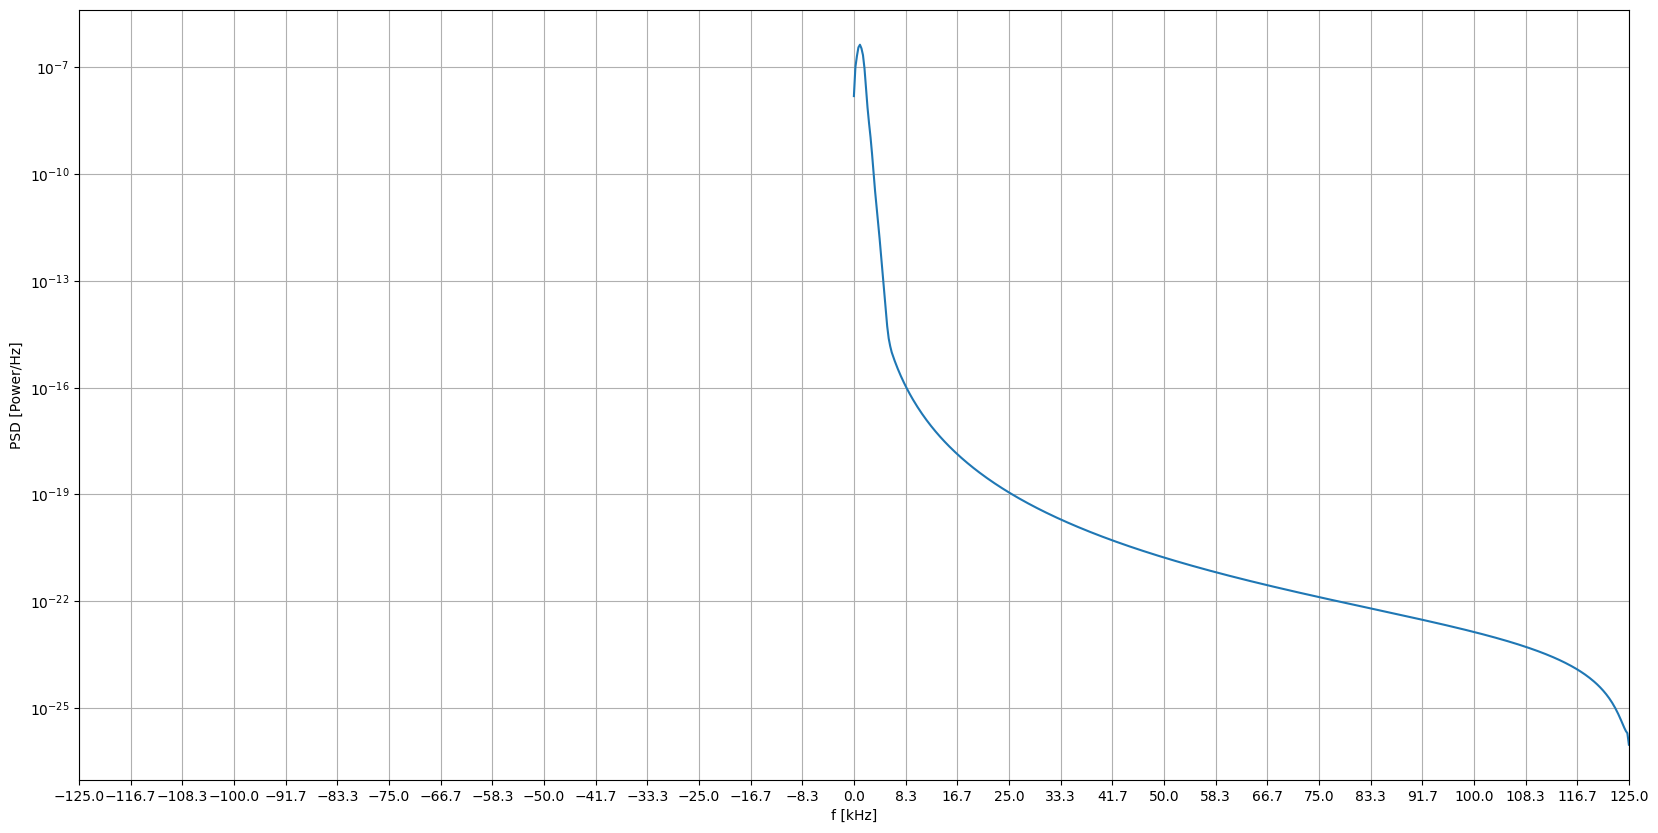

In [78]:
welch(rds_signal_demodulated, sample_rate)

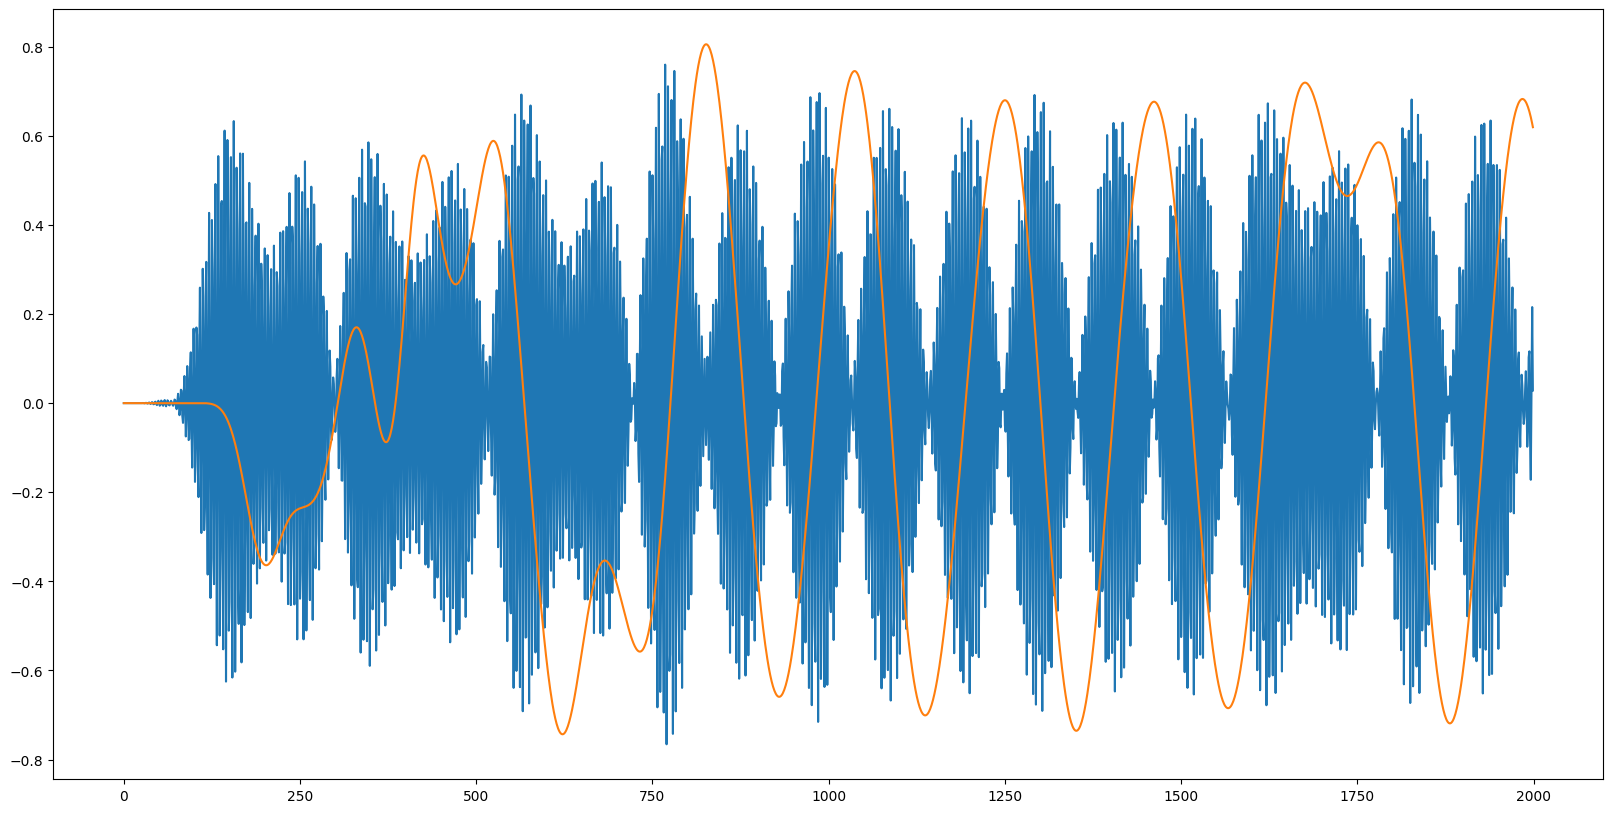

In [79]:
plot_signals([rds_signal, rds_signal_demodulated], start=0, width=2000)

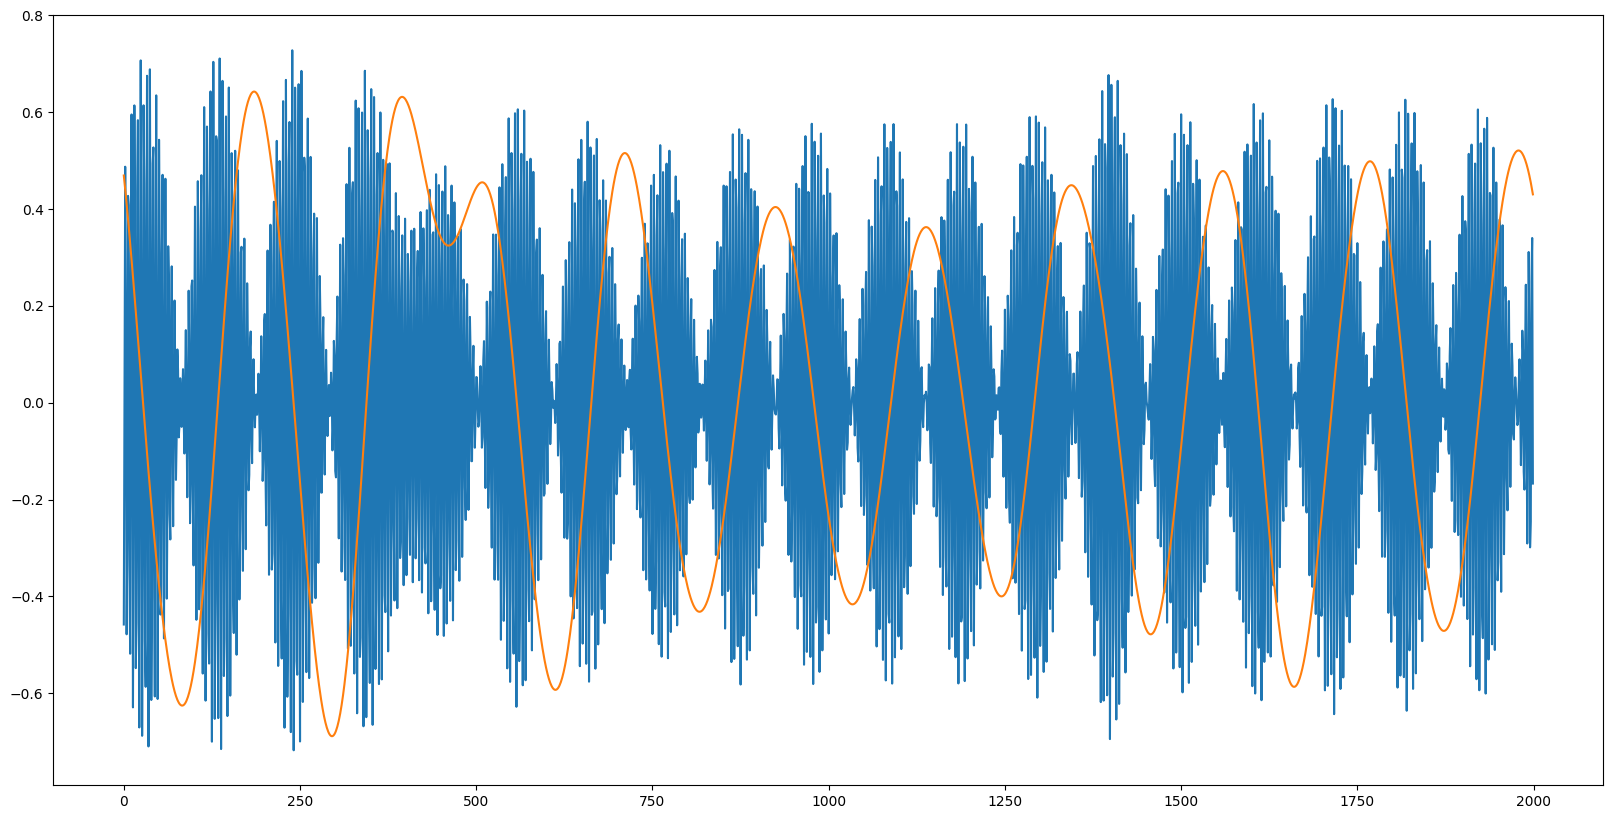

In [80]:
plot_signals([rds_signal, rds_signal_demodulated], start=500000, width=2000)

Very interesting as usual! Demodulated signal follows original (good) but there's a substantial delay (not great but it shouldn't affect data we recover from the signal).

# Timing recovery to get BPSK constellation symbols
Use Mueller & Muller method.

In [81]:
def mm_sync_bpsk(signal, sample_rate, symbol_rate, alpha=0.3):
    samples_per_symbol = sample_rate / symbol_rate
    
    def bpsk_symbol(sample):
        return 2 * int(np.real(sample) > 0) - 1 + 1j * 0

    deltas = []
    sample_indexes = [0]
    i = int(samples_per_symbol)
    delta_t = 0
    
    while i < len(signal):
        sample_indexes.append(i)
        deltas.append(delta_t)
        
        sample_1, sample_2 = signal[sample_indexes[-1]], signal[sample_indexes[-2]]
        symbol_1, symbol_2 = bpsk_symbol(sample_1), bpsk_symbol(sample_2)
        
        mm_delta = np.real(sample_2 * np.conj(symbol_1) - sample_1 * np.conj(symbol_2))
        delta_t += samples_per_symbol + alpha * mm_delta
        
        i += int(delta_t)
        delta_t -= int(delta_t)
    
    return np.array(sample_indexes), np.array(deltas)

In [82]:
symbol_rate = 1187.5
sample_indexes, deltas = mm_sync_bpsk(rds_signal_demodulated, sample_rate, symbol_rate)

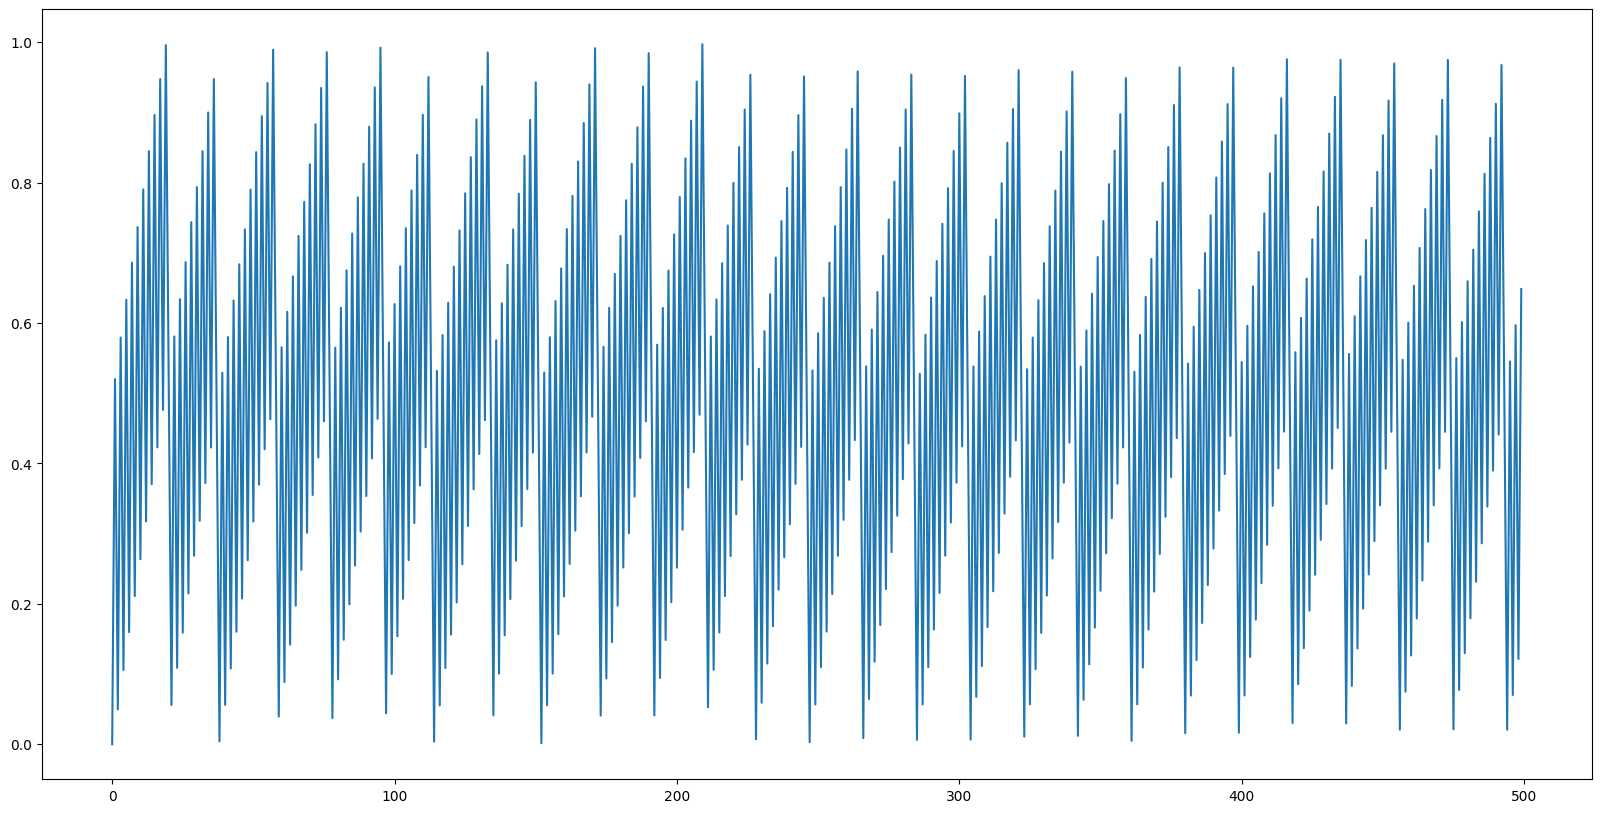

In [83]:
plot_signals([deltas], start=0, width=500)

In [84]:
def plot_signal_with_highlighted(signal, selected_indexes, start=0, width=None):
    fig, ax = plt.subplots()
    fig.set_size_inches((10, 5))
    
    ax.plot(signal[start:start + width])
    
    selected_indexes = [idx for idx in sample_indexes if start <= idx <= start + width]
    ax.plot([idx - start for idx in selected_indexes], [signal[idx] for idx in selected_indexes], '*');

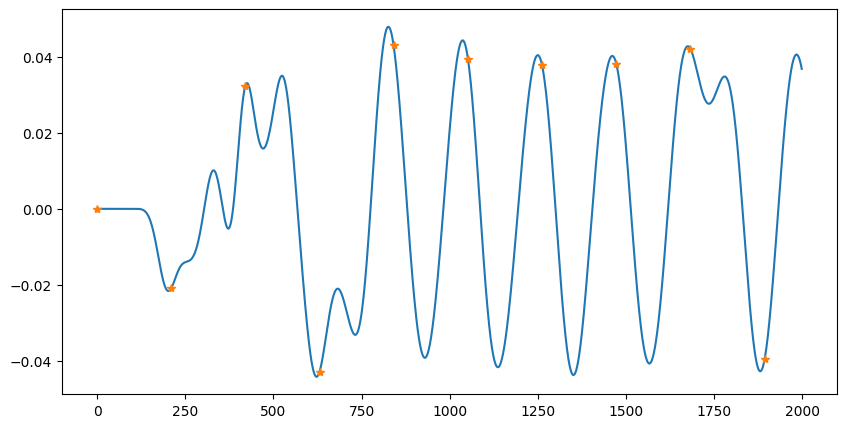

In [85]:
plot_signal_with_highlighted(rds_signal_demodulated, sample_indexes, start=0, width=2000)

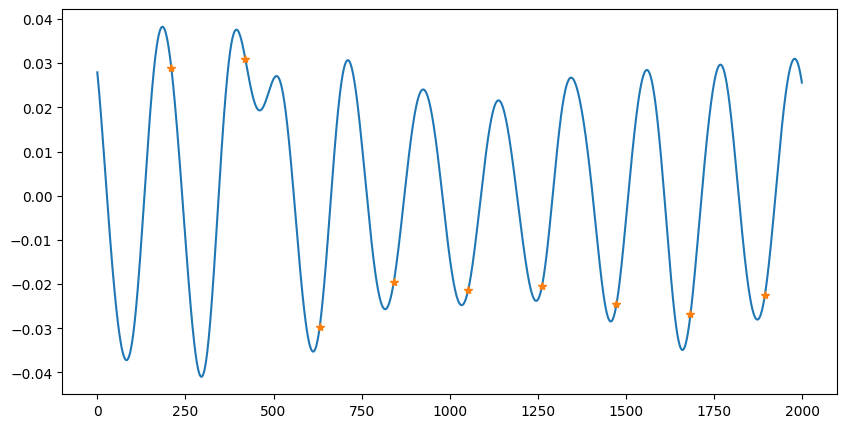

In [86]:
plot_signal_with_highlighted(rds_signal_demodulated, sample_indexes, start=500000, width=2000)

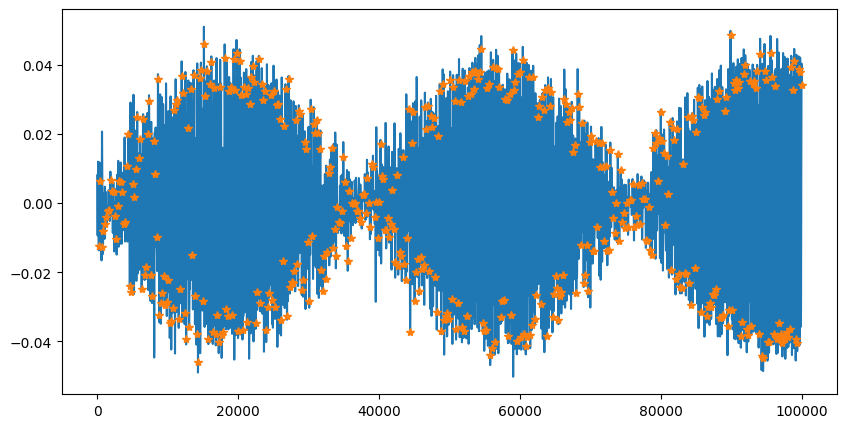

In [87]:
plot_signal_with_highlighted(rds_signal_demodulated, sample_indexes, start=20000, width=100000)

Another mistery - why does the amplitude of demodulated signal vary like that? Looks like it's amplitude is modulated by very low frequency sinusoid with half-period around 38000 samples - perhaps locking onto pilot tone didn't really do the job? We'll see if that's a problem with decoding the data.

In [68]:
print(f'Frequency of modulating sinusoid is around {1 / (2 * 38000 / sample_rate)}Hz.')

Frequency of modulating sinusoid is around 3.2894736842105265Hz.


# BPSK constellation symbols to bits and differential decoding

In [88]:
symbols = rds_signal_demodulated[sample_indexes]
diff_encoded_bits = np.array([int(symbol > 0) for symbol in symbols])

In [89]:
data_bits = np.abs(diff_encoded_bits[1:] - diff_encoded_bits[:-1])

# Error correction and frame synchronization
According to appendix C of EN500067 RDS standard.

In [ ]:
# TODO: calculate syndrome for every bit and acquire sync if you find two correct syndromes n x 26 bits apart - fingers crossed